# Exercise 1: Patients Prescribed Opioids

## Introduction

This notebook explores a FHIR server with a RESTful API which contains data with patients currently prescribed opioids.

### Environment Configuration

First, let's configure the environment with the libraries and settings that will be used throughtout the rest of the exercise.

In [41]:
import json
import requests
import pandas as pd
import pprint
from IPython.display import Markdown, display
import seaborn as sns

pp = pprint.PrettyPrinter(indent=1)

def print_md(string):
    display(Markdown(string))

s = requests.Session()
s.headers.update({'Accept':'application/fhir+json', 'Content-Type': 'application/fhir+json'})
s.verify = False
requests.packages.urllib3.disable_warnings()

FHIR_SERVER = 'https://api.logicahealth.org/opioids/open'

## Querying the Server

All servers are required to support the `capabilities` interaction which documents the server's functionality. The capability interaction is of the form:

`GET [base]/metadata`

📘[Read more about the capabilities interaction](https://www.hl7.org/fhir/http.html#capabilities)

In [2]:
r = s.get(f"{FHIR_SERVER}/metadata")
print(f"HTTP Status Code: {r.status_code}")
capability_statement = r.json()

HTTP Status Code: 200


The HTTP status code, `200 - OK` indicates a successful response. The CapabilityStatement is usually a very large resource so we'll focus on a few key elements.

In [3]:
print(f"FHIR Version Supported: {capability_statement['fhirVersion']}")
print(f"Formats Supported: {', '.join(capability_statement['format'])}")
print()

print(f"Number of RESTful Endpoints: {len(capability_statement['rest'])}")
for rest in capability_statement['rest']:
    print(f"Endpoint Type: {rest['mode']}")

FHIR Version Supported: 4.0.1
Formats Supported: application/fhir+xml, application/fhir+json

Number of RESTful Endpoints: 1
Endpoint Type: server


There is only a single server RESTful endpoint. We can also see the types of FHIR Resources available on this endpoint and the supported operations. Keep in mind that there might not be any data available for a particular FHIR resource even if the server supports that type.

In [4]:
rest = capability_statement['rest'][0]
data = {'Resource': [resource['type'] for resource in rest['resource']],
        'Interaction': [[interaction['code'] for interaction in resource['interaction']] for resource in rest['resource']],
        'Search': [[search['name'] for search in resource['searchParam']] for resource in rest['resource']]}

capabilities_df = pd.DataFrame.from_dict(data)

In [5]:
print('Supported Resources')
display(capabilities_df[['Resource']])

print('Interactions Supported by Resource')
display(capabilities_df.explode('Interaction')[['Resource','Interaction']])

print('Searches Supported by Resource')
display(capabilities_df.explode('Search')[['Resource','Search']])

Supported Resources


,Resource
0,Account
1,ActivityDefinition
2,AdverseEvent
3,AllergyIntolerance
4,Appointment
...,...
141,TestReport
142,TestScript
143,ValueSet
144,VerificationResult


Interactions Supported by Resource


,Resource,Interaction
0,Account,read
0,Account,vread
0,Account,update
0,Account,patch
0,Account,delete
...,...,...
145,VisionPrescription,delete
145,VisionPrescription,history-instance
145,VisionPrescription,history-type
145,VisionPrescription,create


Searches Supported by Resource


,Resource,Search
0,Account,_language
0,Account,owner
0,Account,identifier
0,Account,period
0,Account,patient
...,...,...
145,VisionPrescription,patient
145,VisionPrescription,datewritten
145,VisionPrescription,_id
145,VisionPrescription,encounter


### Querying the Server

The FHIR Spec has a nice summary cheat sheet which is helpful for crafting queries and understanding the resources they return.

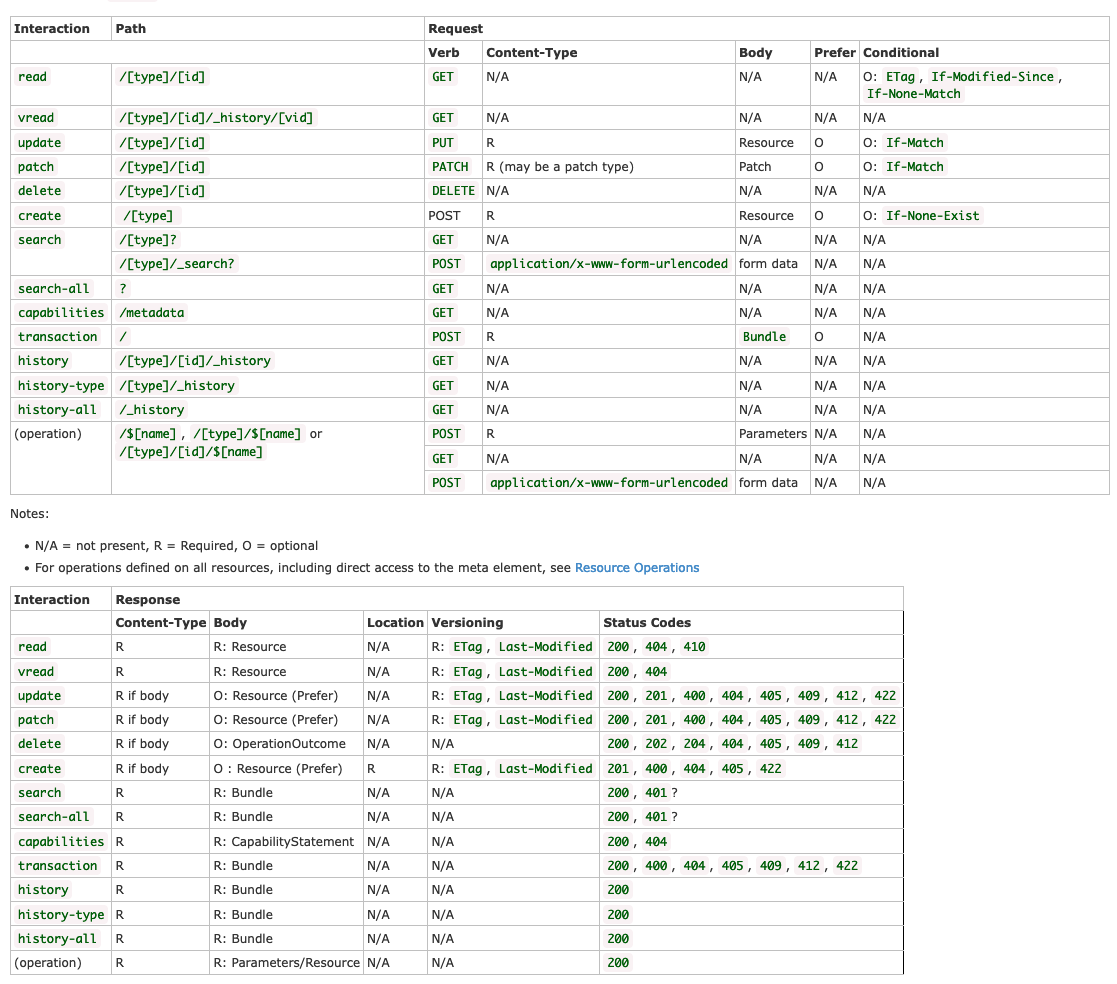

https://www.hl7.org/fhir/http.html#summary

Now that we know a little bit about the server, let's query for all the patients.

In [27]:
r = s.get(f"{FHIR_SERVER}/Patient")
patient_bundle = r.json()

In [7]:
print(f"Resource Type: {patient_bundle['resourceType']}")
print(f"Bundle Type: {patient_bundle['type']}")

Resource Type: Bundle
Bundle Type: searchset


In [29]:
patients = [entry['resource'] for entry in patient_bundle['entry']]

Servers may paginate results when there are too many matches to reasonable return in a single request. Clients can provide a `_count` which suggests to the server how many resources to return in a Bundle. Servers are required to never provide more resources in a single bundle than a client requests with `_count`, but may provide less.

📘[Read more about the FHIR pagination](http://www.hl7.org/fhir/http.html#paging)

📘[Read more about `_count`](https://www.hl7.org/fhir/STU3/search.html#count)

In [30]:
print(f"Number of matches: {patient_bundle['total']}")
print(f"Number of Patients included in Bundle: {len(patient_bundle['entry'])}")

Number of matches: 95
Number of Patients included in Bundle: 50


In this case, there are 96 total patients but only 50 were returned in the bundle.

In [31]:
next_patient_page_url = next(filter(lambda link: link['relation'] == 'next', patient_bundle['link']), None)['url']
print(next_patient_page_url)

https://api.logicahealth.org/opioids/open?_getpages=899ad573-97e8-4ab4-b0ce-31d14aac7d1d&_getpagesoffset=50&_count=50&_pretty=true&_bundletype=searchset


In [32]:
r = s.get(next_patient_page_url)
patient_bundle_2 = r.json()
print(f"Number of Patients included in Bundle: {len(patient_bundle_2['entry'])}")

Number of Patients included in Bundle: 45


In [33]:
has_another_page = True if next(filter(lambda link: link['relation'] == 'next', patient_bundle_2['link']), None) else False
print(has_another_page)

False


Looks like we have all the search results now. We'll package up the pagination code into a method to help automate this process in future requests.

In [34]:
# Resolves all pages for the bundle. Returns an array with all Bundles, including the original Bundle.
def resolve_pages(bundle):
    next_page_link = next(filter(lambda link: link['relation'] == 'next', bundle['link']), None)
    if next_page_link:
        next_page = s.get(next_page_link['url']).json()
        return [bundle] + resolve_pages(next_page)
    else:
        return [bundle]

Now that we can get all the patients, let's grab all the Patients out of the all the Bundles and prepare to do some analysis.

In [35]:
patient_bundles = resolve_pages(patient_bundle)

In [44]:
patients = [entry['resource'] for bundle in patient_bundles for entry in bundle['entry']]
print(f"Total Patient Resources: {len(patients)}")

Total Patient Resources: 95


In [45]:
patients_df = pd.DataFrame(patients)
patients_df.head()

,resourceType,id,meta,text,extension,identifier,name,telecom,gender,birthDate,address,maritalStatus,multipleBirthBoolean,communication,multipleBirthInteger
0,Patient,3437,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Heidenreich818...","[{'system': 'phone', 'value': '555-435-7289', ...",female,1996-02-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
1,Patient,4085,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Konopelski743'...","[{'system': 'phone', 'value': '555-830-4368', ...",female,1997-07-02,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
2,Patient,5072,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Eichmann909', ...","[{'system': 'phone', 'value': '555-956-1828', ...",female,1982-09-19,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
3,Patient,5871,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Kreiger457', '...","[{'system': 'phone', 'value': '555-292-5254', ...",male,1984-12-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
4,Patient,6557,"{'versionId': '1', 'lastUpdated': '2021-12-29T...","{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Rowe323', 'giv...","[{'system': 'phone', 'value': '555-529-4121', ...",female,1998-06-29,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN


# FHIR Resources and Data Frames

Panda DataFrames are 2-dimensional data structures suited for tabular data. FHIR Resources vary widely and are deeply nested and although pandas does have functionality to normalize semi-structured data into a flat table, it's not well suited to nested arrays within a FHIR Resource.

There are numerous approaches to loading FHIR into DataFrames and the approach, or combination of approaches, taken may be driven by the use case.

In the beginning of the notebook when we were dealing with the CapabilityStatement, we did some data crunching up front before loading anything into a DataFrame to only keep the data we cared about. That worked well in our scenario since we only cared about a few deeply nested fields as part of our analysis which resulted in a smaller DataFrame that was easier to manage. Some of the fields as array values in the table since they were simple enough to exploded into the views we cared about, but we could have further normalized the table into rows manually if we wished.

The `patients_df` above has minimal processing applied and loads the patients directly into a DataFrame. This works well for top-level primitive FHIR elements in the resource (like `gender` and `birthDate`), but isn't optimal for complex elements, like `maritalStatus`, or arrays of elements, like `identifier`.

Below we can see that pandas built in `json_normalize` method can help some with complex elements and breaks up fields like `maritalStatus` into its individual elements, while still keeping a single row per patient. If we only cared about `maritalStatus.text` for our analysis this could be a nice approach compared to writing list comprehensions or lambdas to retrieve these elements, whether before or after the data is turned into a DataFrame. Note that the arrays of elements, including `maritalStatus.coding`, still aren't exploded out in these views. One method of breaking out the identifiers is shown on the next line.

As expected, there are many ways to process FHIR data and in these exercises we'll focus more on how to find the data you need in FHIR over how the data is processed.

📘[Read more about `pandas.json_normalize`](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html)

📘[Read more about `Pandas DataFrames`](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html#dataframe)

In [74]:
patients_jn = pd.json_normalize(patients, max_level=10)
patients_jn.head()

,resourceType,id,extension,identifier,name,telecom,gender,birthDate,address,multipleBirthBoolean,communication,meta.versionId,meta.lastUpdated,meta.source,meta.profile,text.status,text.div,maritalStatus.coding,maritalStatus.text,multipleBirthInteger
0,Patient,3437,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Heidenreich818...","[{'system': 'phone', 'value': '555-435-7289', ...",female,1996-02-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:30:21.000+00:00,#mUW5Jy6Tl3uauUnB,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,Never Married,NaN
1,Patient,4085,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Konopelski743'...","[{'system': 'phone', 'value': '555-830-4368', ...",female,1997-07-02,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:37:18.000+00:00,#yTw02TRSmhZHShp5,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,Never Married,NaN
2,Patient,5072,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Eichmann909', ...","[{'system': 'phone', 'value': '555-956-1828', ...",female,1982-09-19,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:40:43.000+00:00,#yPKbh9jQquRHQmE7,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,M,NaN
3,Patient,5871,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Kreiger457', '...","[{'system': 'phone', 'value': '555-292-5254', ...",male,1984-12-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:43:46.000+00:00,#iPi8Jpw3DEDTG7KX,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,M,NaN
4,Patient,6557,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Rowe323', 'giv...","[{'system': 'phone', 'value': '555-529-4121', ...",female,1998-06-29,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:46:51.000+00:00,#gaWF7ivOUHNBkp1R,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,Never Married,NaN


In [81]:
identifiers_table = patients_df.groupby('id').identifier.apply(lambda x: pd.DataFrame(x.values[0])).reset_index()
identifiers_table.head()

,id,level_1,system,value,type
0,10098,0,https://github.com/synthetichealth/synthea,2417861b-0aeb-6be0-7ee4-8d4da85dd96f,NaN
1,10098,1,http://hospital.smarthealthit.org,2417861b-0aeb-6be0-7ee4-8d4da85dd96f,{'coding': [{'system': 'http://terminology.hl7...
2,10098,2,http://hl7.org/fhir/sid/us-ssn,999-58-1613,{'coding': [{'system': 'http://terminology.hl7...
3,10098,3,urn:oid:2.16.840.1.113883.4.3.25,S99985515,{'coding': [{'system': 'http://terminology.hl7...
4,10098,4,http://standardhealthrecord.org/fhir/Structure...,X16167510X,{'coding': [{'system': 'http://terminology.hl7...


## Patient Demographics

Now that we have all our patients, let's try and analyze their demographics

<AxesSubplot:ylabel='gender'>

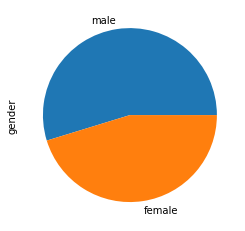

In [43]:
patients_df['gender'].value_counts().plot.pie()

,resourceType,id,extension,identifier,name,telecom,gender,birthDate,address,multipleBirthBoolean,communication,meta.versionId,meta.lastUpdated,meta.source,meta.profile,text.status,text.div,maritalStatus.coding,maritalStatus.text,multipleBirthInteger
0,Patient,3437,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Heidenreich818...","[{'system': 'phone', 'value': '555-435-7289', ...",female,1996-02-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:30:21.000+00:00,#mUW5Jy6Tl3uauUnB,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,Never Married,NaN
1,Patient,4085,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Konopelski743'...","[{'system': 'phone', 'value': '555-830-4368', ...",female,1997-07-02,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:37:18.000+00:00,#yTw02TRSmhZHShp5,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,Never Married,NaN
2,Patient,5072,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Eichmann909', ...","[{'system': 'phone', 'value': '555-956-1828', ...",female,1982-09-19,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:40:43.000+00:00,#yPKbh9jQquRHQmE7,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,M,NaN
3,Patient,5871,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Kreiger457', '...","[{'system': 'phone', 'value': '555-292-5254', ...",male,1984-12-26,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:43:46.000+00:00,#iPi8Jpw3DEDTG7KX,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,M,NaN
4,Patient,6557,[{'url': 'http://hl7.org/fhir/us/core/Structur...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Rowe323', 'giv...","[{'system': 'phone', 'value': '555-529-4121', ...",female,1998-06-29,[{'extension': [{'url': 'http://hl7.org/fhir/S...,False,[{'language': {'coding': [{'system': 'urn:ietf...,1,2021-12-29T23:46:51.000+00:00,#gaWF7ivOUHNBkp1R,[http://hl7.org/fhir/us/core/StructureDefiniti...,generated,"<div xmlns=""http://www.w3.org/1999/xhtml"">Gene...",[{'system': 'http://terminology.hl7.org/CodeSy...,Never Married,NaN


In [71]:
# identifiers_table = patients_df['identifier'][0]
# patients_df.iloc[0]['identifier'][0]['system']
identifiers_table = patients_df[['id','identifier']]
identifiers_table.groupby('id').identifier.apply(lambda x: pd.DataFrame(x.values[0])).reset_index()

,id,level_1,system,value,type
0,10098,0,https://github.com/synthetichealth/synthea,2417861b-0aeb-6be0-7ee4-8d4da85dd96f,NaN
1,10098,1,http://hospital.smarthealthit.org,2417861b-0aeb-6be0-7ee4-8d4da85dd96f,{'coding': [{'system': 'http://terminology.hl7...
2,10098,2,http://hl7.org/fhir/sid/us-ssn,999-58-1613,{'coding': [{'system': 'http://terminology.hl7...
3,10098,3,urn:oid:2.16.840.1.113883.4.3.25,S99985515,{'coding': [{'system': 'http://terminology.hl7...
4,10098,4,http://standardhealthrecord.org/fhir/Structure...,X16167510X,{'coding': [{'system': 'http://terminology.hl7...
...,...,...,...,...,...
470,9367,0,https://github.com/synthetichealth/synthea,9e90ab3e-b8ad-f6a3-98fc-282e57ce6eef,NaN
471,9367,1,http://hospital.smarthealthit.org,9e90ab3e-b8ad-f6a3-98fc-282e57ce6eef,{'coding': [{'system': 'http://terminology.hl7...
472,9367,2,http://hl7.org/fhir/sid/us-ssn,999-54-9524,{'coding': [{'system': 'http://terminology.hl7...
473,9367,3,urn:oid:2.16.840.1.113883.4.3.25,S99921435,{'coding': [{'system': 'http://terminology.hl7...
